In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge,RANSACRegressor,Lasso
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, RocCurveDisplay, mean_squared_error, mean_squared_log_error, roc_curve, PrecisionRecallDisplay, r2_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor

c:\Users\cdnec\MarketPulse\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
docs = pd.read_parquet('../data/sts_gb.parquet').set_index('date').squeeze()#['statement']

In [93]:
y = pd.read_parquet('../data/prices.parquet')
y=y.asfreq('D').bfill().loc[docs.index]
y = y.dropna(axis=1)

In [4]:
model_name = 'philschmid/bge-base-financial-matryoshka'
# model_name = 'FinLang/finance-embeddings-investopedia'

In [5]:
encoder = SentenceTransformer(model_name)

In [6]:
X = encoder.encode(docs.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2, shuffle=False)

In [142]:
pearsonr([1,2,7.8,54],[6, 2.5, 987, 3]).confidence_interval()

ConfidenceInterval(low=-0.9750431016983874, high=0.9395655927453249)

In [167]:
def multioutput_scorer(scorer, y_true, y_pred, **kwargs):
    def f(series, scorer, **kwargs):
        score = scorer(series['y_true'], series['y_pred'])
        try:
            ci = score.confidence_interval()
        except AttributeError:
            return {'Score':score}
        else:
            return dict(['low', 'high'])
    y_pred = pd.DataFrame(y_pred, index=y_true.index, columns=y_true.columns)
    df = pd.concat([y_true, y_pred], keys=['y_true', 'y_pred'])
    results = df.apply(f, scorer=scorer, result_type='expand', **kwargs)
    return results.T

In [96]:
scaler=make_pipeline(
    StandardScaler(), 
    PCA(64, whiten=True)
)
y_scaler=StandardScaler()

In [97]:
def gs(y,p):
    r=spearmanr(y, p)
    return r.statistic-r.pvalue
def gp(y,p):
    r=pearsonr(y, p)
    return r.statistic-r.pvalue

In [98]:
reg=LinearRegression()
model = make_pipeline(
    PCA(
            16,
            # whiten=True
        ),
    reg
)

In [99]:
model.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=16)),
                ('linearregression', LinearRegression())])

In [100]:
p_train = model.predict(X_train)
p_val = model.predict(X_val)

In [101]:
def get_optimal_threshold(y, p):
    fpr, tpr, thresholds = roc_curve(y>0, p, drop_intermediate=True)
    opt_idx = np.argmax(tpr-fpr)
    # print(opt_idx)
    return thresholds[opt_idx]

In [102]:
thresholds = [get_optimal_threshold(y, p) for y, p in zip(y_train.values.T, p_train.T)]

In [103]:
y_true, y_pred = y_val, p_val

In [108]:
results = {
    'mse':multioutput_scorer(mean_squared_error, y_true, y_pred),
    'acc':multioutput_scorer(balanced_accuracy_score, y_true>0, y_pred>thresholds)
}

In [150]:
results = pd.concat(results, names=['Metric', ]).rename('Score').reset_index()

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [117]:
u=results['Ticker'].unique()

In [168]:
results = multioutput_scorer(balanced_accuracy_score, y_true>0, y_pred>thresholds)

AttributeError: 'numpy.float64' object has no attribute 'confidence_interval'

In [166]:
results

Score
Period Ticker          
1      ^GSPC   0.617647
       ^IRX    0.538462
       ^IXIC   0.634804
       ^RUT    0.579327
       ^TYX    0.507212
...                 ...
30     ^IRX    0.550595
       ^IXIC   0.658654
       ^RUT    0.688095
       ^TYX    0.530952
       ^VIX    0.686869

[180 rows x 1 columns]

In [132]:
# for _,grp in results.groupby('Metric'):
#     break
# sns.heatmap(grp.pivot(index='Ticker', columns='Period', values='Score'), vmin=.5)

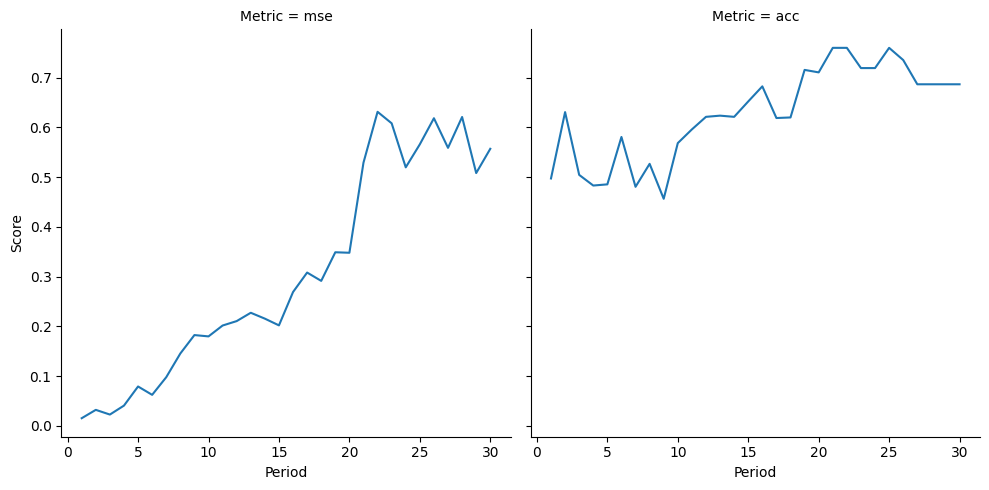

In [123]:
r=results[results['Ticker']==u[6]]
sns.relplot(r, x='Period', y='Score', col='Metric', kind='line')